# Multi-Label Classification Lab

Welcome to the Multi-Label Image Classification Lab! By the end of this lab, you will have

- Implemented a multi-label image classification model
- Gained intuition for how a CNN learns to predict multiple classes
- Used data augmentation to maximize the effective size of your training set

# Load MNIST Images

The following code loads MNIST images and normalizes them. It also displays the first five images in the dataset.

In [15]:
from IPython.display import display
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import array_to_img, img_to_array

[X_mnist, y_mnist], _ = mnist.load_data()
X_mnist = X_mnist.astype(np.float) / 255.

for x in X_mnist[:5]:
    x = np.expand_dims(x, axis=0)
    img = array_to_img(x, data_format='channels_first')
    display(img)
    
X_mnist.shape

(60000, 28, 28)

# Concatenate Images

The following code creates images of the form

| Left | Right |
|:----:|:-----:|
| $\mathbb{N}_9$ - $\{3\}$ | $\mathbb{N}_9$ |

where $\mathbb{N}_n$ are the digits $(0, 1, \ldots, n)$.

In [16]:
from keras.preprocessing.image import array_to_img

nb_train = 10_000
nb_mnist = len(y_mnist)

X, y = np.zeros([nb_train, X_mnist.shape[1], X_mnist.shape[2]*2]), np.zeros([nb_train, 2], dtype=np.uint)
i = 0
while i < nb_train:
    j, k = np.random.choice(nb_mnist, size=2)
    if y_mnist[j] == 3 or (y_mnist[j] == y_mnist[k]):
        continue
    
    X[i] = np.concatenate([X_mnist[j], X_mnist[k]], axis=1)
    y[i] = [y_mnist[j], y_mnist[k]]
    i += 1

for idx in range(5):
    x, y_ = X[idx], y[idx]
    img = array_to_img(np.expand_dims(X[idx], axis=0), data_format='channels_first')
    print(y_)
    display(img)

[6 7]


[7 8]


[2 8]


[9 2]


[1 3]


## Task

- Transform the list of lists $y \in \mathbb{R}^{N \times 2}$ into a categorical numpy array $Y \in \mathbb{R}^{N \times 10}$ where $Y_{ij} = 1$ if $j \in y_{[i:]}$ and $0$ otherwise
    - $y_{[i:]}$ denotes the $i$th row of $y$

## Hints

- You are essentially implementing `keras.utils.np_utils.to_categorical()` but for multi-label data instead of one-hot labels

In [17]:
Y = np.zeros([nb_train, 10])

for i, (d1, d2) in enumerate(y):
    Y[[i, i], [d1, d2]] = 1

## Multi-Label Logistic Regression Classifier

The following code creates a multi-label logistic regression classifier to predict images with multiple MNIST digits.

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.constraints import nonneg

model = Sequential()
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(units=10, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                15690     
Total params: 15,690.0
Trainable params: 15,690.0
Non-trainable params: 0.0
_________________________________________________________________


## Question

- Why is `categorical_crossentropy` a poor choice of loss to use over `binary_crossentropy` for multi-label classification?

## Answer

- `categorical_crossentropy` only computes gradients on predicted scores which line up with values of `1`.

## Question

- Why is a sigmoid activation more appropriate than a softmax activation for multi-label classification?

## Answer

- In multi-label classification, we desire to have multiple normalized class scores to be as close to one as possible. When the number of labels present in each data point is equal to 2, the optimal softmax setting will only yield class scores of 0.5 for softmax (in the limit), whereas softmax will yield 1.0 for each (in the limit).

## Question

- What piece of training information do we lose when we convert $y$ to $Y$?

## Answer

- The ordering in of the digits is lost in this representation.

## Callback to Measure Accuracy on Threes

The following callback takes a set of images and filters them down to only those of the form

| Left | Right |
|:----:|:-----:|
| $\mathbb{N}_9$ - $\{3\}$ | $3$ |

It then flips all of these images to make another set of images of the form

| Left | Right |
|:----:|:-----:|
| $3$ | $\mathbb{N}_9$ - $\{3\}$ |

The model is evaluated on how well it predicts the presence of a 3. Concretely it computes multiclass accuracy on the digit 3 where a prediction of class scores is deemed "correct" if the class score for 3 is either the highest or second-highest.

In [19]:
import IPython
import copy
import keras
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

class ThreeAccuracyCallback(keras.callbacks.Callback):
    def __init__(self, X, y, plot=True):
        three_idxs = np.argwhere(y[:, 1] == 3).flatten()
        self.X3 = X[three_idxs]
        self.X3_flipped = np.array([self._reverse(x) for x in self.X3])
        self.nb_3 = len(self.X3)
        self.plot = plot
        
    def _reverse(self, x):
        x = copy.deepcopy(x)
        left, right = copy.deepcopy(x[:, :28]), copy.deepcopy(x[:, 28:])
        x[:, :28], x[:, 28:] = right, left
        return x
        
    def on_epoch_end(self, epoch, logs={}):
        Y3_pred, Y3_flipped_pred = self.model.predict(self.X3), self.model.predict(self.X3_flipped)
        y3_pred, y3_flipped_pred = np.argsort(-Y3_pred)[:, :2], np.argsort(-Y3_flipped_pred)[:, :2]
        
        logs['3 accuracy'] = np.sum(np.argsort(-Y3_pred)[:, :2] == 3, axis=1).mean()
        logs['flipped 3 accuracy'] = np.sum(np.argsort(-Y3_flipped_pred)[:, :2] == 3, axis=1).mean()
        
        # Display sample image
        if not self.plot:
            return
            
        IPython.display.clear_output()
        idx = np.random.choice(self.nb_3)
        x3, x3_flipped = self.X3[idx], self.X3_flipped[idx]
        x3 = np.expand_dims(x3, axis=-1) if x3.ndim == 2 else x3
        x3_flipped = np.expand_dims(x3_flipped, axis=-1) if x3_flipped.ndim == 2 else x3_flipped
        y3_pred, y3_flipped_pred = Y3_pred[idx], Y3_flipped_pred[idx]
        display(array_to_img(x3, data_format='channels_last'))
        pd.Series(y3_pred).plot(kind='bar')
        plt.show()
        display(array_to_img(x3_flipped, data_format='channels_last'))
        pd.Series(y3_flipped_pred).plot(kind='bar')
        plt.show()

## Fit the Model

The following code fits a multi-label logistic regression model to the multi-digit MNIST images and uses an `AccuracyCallback` for evaluation.

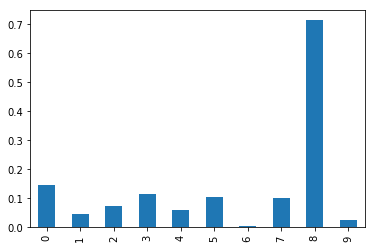

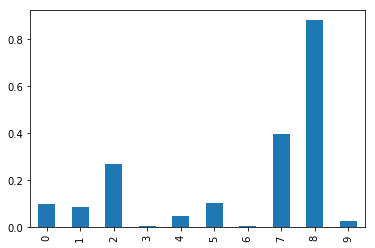

9000/9000 [==============================] - 1s - loss: 0.1771     


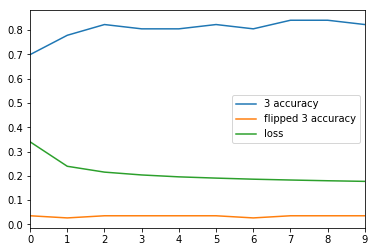

In [20]:
import pandas as pd
%matplotlib inline

Y = np.zeros([nb_train, 10])
for i, (d1, d2) in enumerate(y):
    Y[[i, i], [d1, d2]] = 1

X_train, Y_train = X[:-nb_train//10], Y[:-nb_train//10]
X_val, y_val = X[-nb_train//10:], y[-nb_train//10:]

history = model.fit(X_train, Y_train, callbacks=[ThreeAccuracyCallback(X_val, y_val)])
pd.DataFrame(history.history).plot();

# Display Learned Weights

The following code displays the learned multi-label logistic regression weights for each digit class.

In [21]:
from IPython.display import display

W, b = model.layers[-1].get_weights()
for d in range(10):
    w0 = W[:, d].reshape(*X.shape[1:])
    img = array_to_img(np.expand_dims(w0, axis=0), data_format='channels_first')
    print(d)
    display(img)

0


1


2


3


4


5


6


7


8


9




Once again the model is awarded a point if it awards 3 one of the top two scores.

# Convert `X` to TensorFlow Format

The following code converts `X` which has shape `(10000, 28, 56)` data into a variable `X_tf` which is suitable for use with TensorFlow and has shape `(10000, 28, 56, 1)`.

In [22]:
from keras.preprocessing.image import img_to_array

imgs = [array_to_img(x, data_format='channels_first') for x in np.expand_dims(X, axis=1)]

X_tf = np.array([img_to_array(img) for img in imgs])
X_tf = X_tf.astype(np.float) / 255.
X_tf_train, X_tf_val = X_tf[:-nb_train//10], X_tf[-nb_train//10:]

X_tf.shape

(10000, 28, 56, 1)

## Task

- Define a CNN model to maximize the accuracy of both images with the number 3 and when these numbers have been swapped

## Requirements

- You may only use `Conv2D`, `MaxPool2D`, `ReLU`, `Flatten`, `Dense`, and `Sigmoid` layers
- Use the `ThreeAccuracyCallback` for evaluation
- Use the `adam` optimizer by specifying `keras.models.Model.compile(..., optimizer='adam')` and do not adjust the default learning rate
- You are limited to `X_tf_train` and `X_tf_val` and may *not* use any kind of data augmentation

## Hints

- Use your intuitions of max-pooling and convolution for narrowing down your architecture search

# Shallow CNN Model

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D
from keras.constraints import nonneg

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=10, activation='relu', input_shape=[28, 56, 1]))
model.add(MaxPool2D(pool_size=[2, 2]))
model.add(Flatten())
model.add(Dense(units=10, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 19, 47, 64)        6464      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 23, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 13248)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                132490    
Total params: 138,954.0
Trainable params: 138,954.0
Non-trainable params: 0.0
_________________________________________________________________


# Fit the Model

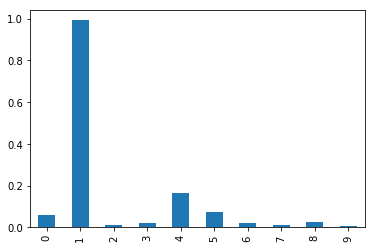

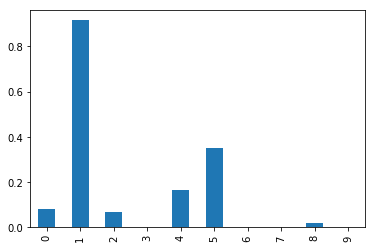

9000/9000 [==============================] - 29s - loss: 0.1979    


{'3 accuracy': [0.91150442477876104],
 'flipped 3 accuracy': [0.061946902654867256],
 'loss': [0.19786994492345386]}

In [24]:
history = model.fit(X_tf_train, Y_train, epochs=1, callbacks=[ThreeAccuracyCallback(X_tf_val, y_val)])
history.history

# 3-Layer CNN

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D
from keras.constraints import nonneg

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[28, 56, 1]))
model.add(MaxPool2D(pool_size=[2, 2]))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=[2, 2]))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=[2, 2]))
model.add(Flatten())
model.add(Dense(units=10, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 12, 32)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 10, 64)         18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 5, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 320)               0         
__________

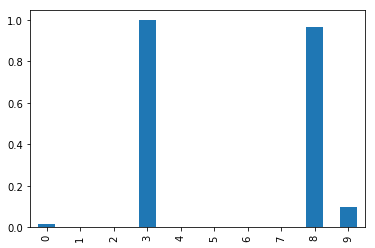

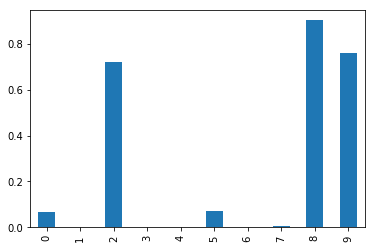

9000/9000 [==============================] - 19s - loss: 0.0909    


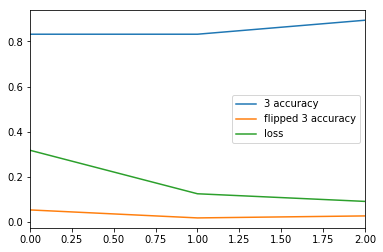

In [26]:
history = model.fit(X_tf_train, Y_train, epochs=3, callbacks=[ThreeAccuracyCallback(X_tf_val, y_val)])
pd.DataFrame(history.history).plot();

# Aggressive Max-Pooling

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D
from keras.constraints import nonneg

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=10, activation='relu', input_shape=[28, 56, 1]))
model.add(MaxPool2D(pool_size=[19, 47]))
model.add(Flatten())
model.add(Dense(units=10, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 19, 47, 64)        6464      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 7,114.0
Trainable params: 7,114.0
Non-trainable params: 0.0
_________________________________________________________________


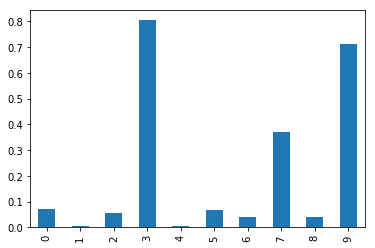

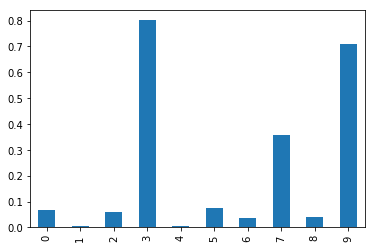

9000/9000 [==============================] - 24s - loss: 0.2625    


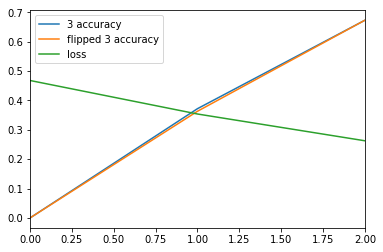

In [28]:
history = model.fit(X_tf_train, Y_train, epochs=3, callbacks=[ThreeAccuracyCallback(X_tf_val, y_val)])
pd.DataFrame(history.history).plot();

# Question

- What architectural choice was necessary to include to increase prediction on the test set? Concretely, list the hyperparameter values that worked. Justify why inclusion of this architectural property is necessary for the model to make accurate predictions on the test set.